In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.style.use("seaborn-darkgrid")

# Load the databases

In [2]:
kills = pd.read_csv('kills.csv', sep=",")
gold = pd.read_csv('gold.csv', sep=",")
bans = pd.read_csv('bans.csv', sep=",")
LeagueOfLegends = pd.read_csv('LeagueOfLegends.csv', sep=",")
matchinfo = pd.read_csv('matchinfo.csv', sep=",")
monsters = pd.read_csv('monsters.csv', sep=",")
structures = pd.read_csv('structures.csv', sep=",")

# Starting the analysis
As a league player myself, I always suspected that the botlane is the key factor for a team succeding... maybe until the recent season 8 patches though :D ... Lets start with that

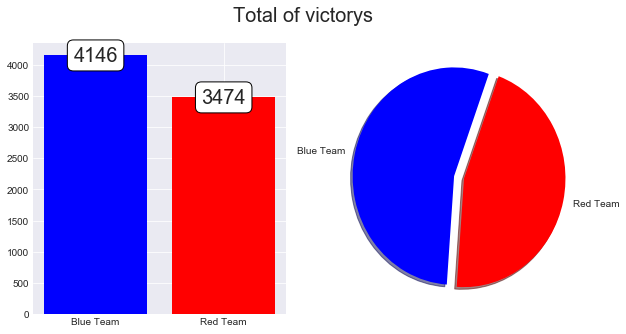

In [3]:
#totals
BlueTeamVictoryPerc = LeagueOfLegends['bResult'].sum()
RedTeamVictoryPerc = LeagueOfLegends['rResult'].sum()
group = (BlueTeamVictoryPerc, RedTeamVictoryPerc)
fig, axes = plt.subplots(1, 2,figsize=(10,5))
fig.suptitle('Total of victorys', fontsize=20)
#bar indexes
cats = ['Blue Team', 'Red Team']
data = [BlueTeamVictoryPerc, RedTeamVictoryPerc]
axes[0].bar(cats, data, color=['blue', 'red'])
axes[1].pie(data, colors=['blue', 'red'], explode=[0.1, 0], labels=cats, startangle=70, shadow="True")
for x,y in zip([0,1], data):
    #data labels
    axes[0].annotate('{0}'.format(y), xy=(x, y), ha="center", va="center", bbox={'boxstyle':'round', 'fc':'w'}, size=20)

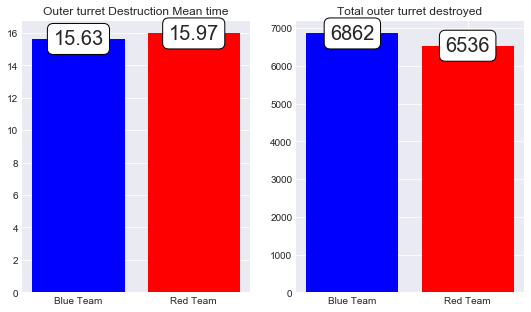

In [4]:
#First the time mean
outer_turret_times_mean = [structures.loc[(structures['Team'] == team) & (structures['Type'] == 'OUTER_TURRET') & \
                                    (structures['Lane'] == 'BOT_LANE'), 'Time'].mean() for team in ('bTowers', 'rTowers')]
outer_turret_count = [structures.loc[(structures['Team'] == team) & (structures['Type'] == 'OUTER_TURRET') & \
                                     (structures['Lane'] == 'BOT_LANE'), 'Type'].count() for team in ('bTowers', 'rTowers')]
fig, axes = plt.subplots(1, 2, figsize=(9,5))

axes[0].bar(cats, outer_turret_times_mean, color = ['blue', 'red'])
axes[1].bar(cats, outer_turret_count, color = ['blue', 'red'])

axes[0].set_title('Outer turret Destruction Mean time')
axes[1].set_title('Total outer turret destroyed')

#annotate data labels on bars
for x, median, count in zip([0,1], outer_turret_times_mean, outer_turret_count):
    axes[0].annotate('{0:.2f}'.format(median), xy=(x, median), ha = 'center', va = 'center',\
                     bbox = {'boxstyle':'round', 'fc':'w'}, size=20)
    axes[1].annotate('{0}'.format(count), xy=(x, count), ha = 'center', va = 'center',\
                     bbox = {'boxstyle':'round', 'fc':'w'}, size=20)

# So we can supose...
Yes, the outcome in the botlane seems to reflect directly in the game since the blue team has the most wins, less mean outer's turret destruction time and plus the highest number of turrets destroyed in total. It can mean that the team on the blue's side unintentionally or not play more towards the botlane or even just have a natural advantage.  

# Lets check the Dragon, Baron and Herald...

In [5]:
print('Got {0} null values'.format(monsters['Team'].isnull().sum()))

Got 0 null values


In [6]:
def ReplaceCats(cat):
    if cat[0] == 'r':
        return " ".join(('Red team', cat[1:]))
    else:
        return " ".join(('Blue team', cat[1:]))

Text(0.5,1,'Total monsters killed')

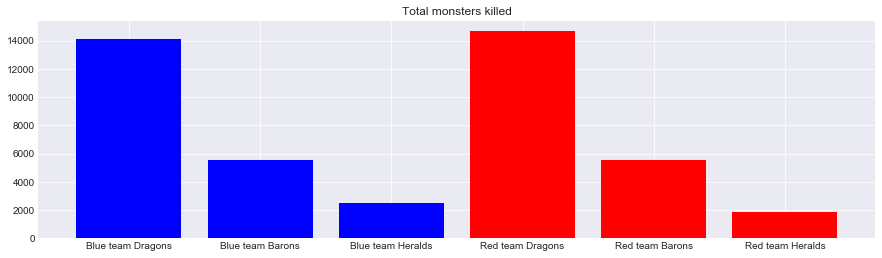

In [7]:
#Get the categorys
cats = monsters['Team'].unique()
#Count based on categorys
count_data = [monsters.loc[(monsters['Team'] == cat),'Team'].count() for cat in cats]
cats = pd.Series(monsters['Team'].unique()).map(ReplaceCats)
fig, axes = plt.subplots(figsize=(15,4))
colors = ['blue' if 'Blue' in cat else 'red' for cat in cats]
axes.bar(cats.values, count_data, color = colors)
axes.set_title('Total monsters killed')

# Champions compositions

C:\Users\thiag\AppData\Local\Continuum\anaconda3\envs\dlnd\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


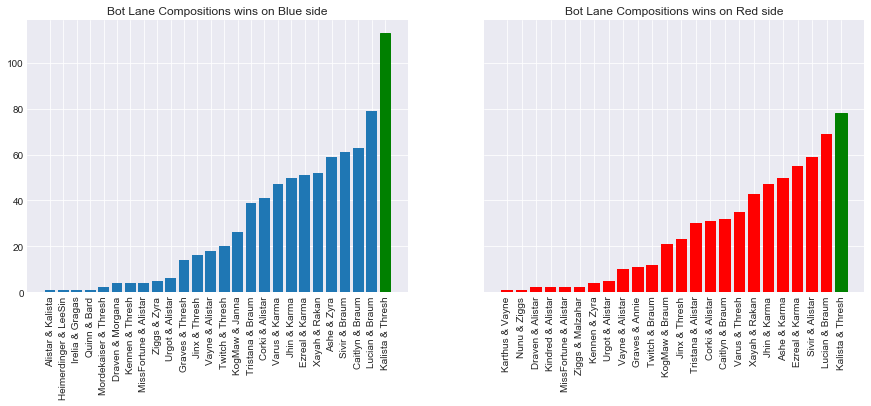

In [8]:
#champ related cols
champs_cols = [col for col in matchinfo.columns if 'Champ' in col]

#Get each team botlane duos
blue_bot_lanes = matchinfo[matchinfo['bResult'] == 1].groupby(['blueADCChamp', 'blueSupportChamp']).count()['bResult']
red_bot_lanes = matchinfo[matchinfo['rResult'] == 1].groupby(['redADCChamp', 'redSupportChamp']).count()['bResult']

#Get the ad carrys
blue_adcs, red_adcs = blue_bot_lanes.index.levels[0], red_bot_lanes.index.levels[0]

#Get the duos with highest number of victorys
most_blue_victorious_duos = [[adc, np.argmax(blue_bot_lanes[adc]), blue_bot_lanes[adc].max()] for adc in blue_adcs]
most_red_victorious_duos = [[adc, np.argmax(red_bot_lanes[adc]), red_bot_lanes[adc].max()] for adc in red_adcs]

#sorting for plot
most_blue_victorious_duos.sort(key=lambda x: x[-1])
most_red_victorious_duos.sort(key=lambda x: x[-1])

#summaryzing the data for plot
def label_victorys_summary(most_team_victorious_duos):
    labels, num_victorys = list(), list()
    for adc, supp, n_victorys in most_team_victorious_duos:
        labels.append(" & ".join((adc, supp)))
        num_victorys.append(n_victorys)
    return labels, num_victorys
blue_labels, blue_victorys = label_victorys_summary(most_blue_victorious_duos)
red_labels, red_victorys = label_victorys_summary(most_red_victorious_duos)

#plotting
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
blue_bars = axes[0].bar(blue_labels, blue_victorys)
axes[0].set_title('Bot Lane Compositions wins on Blue side')
axes[1].set_title('Bot Lane Compositions wins on Red side')
blue_bars[np.argmax(blue_victorys)].set_color('g')
red_bars = axes[1].bar(red_labels, red_victorys, color = 'r')
red_bars[np.argmax(red_victorys)].set_color('g')
for label in axes[0].get_xticklabels():
    label.set_rotation(90)
for label in axes[1].get_xticklabels():
    label.set_rotation(90)

# Kalista and Thresh rules
The most dominant duo, a litle bit of a surprise since Kalista have never been considered this dominant as a AD Carry, but it seems that the sinergy with Thresh does pay off. Interesting to see since most players just take the adc matchup in consideration and give almost no thoughts on the support matchup.

# Now lets look at the jungle.

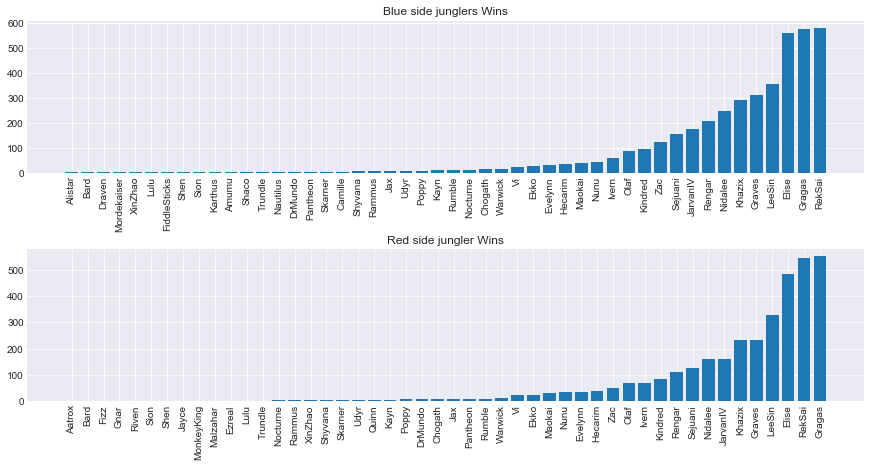

In [9]:
#Counting and sorting the junglers
blue_junglers = matchinfo[matchinfo['bResult'] == 1].groupby('blueJungleChamp').count()['bResult'].sort_values(ascending=True)
red_junglers = matchinfo[matchinfo['rResult'] == 1].groupby('redJungleChamp').count()['rResult'].sort_values(ascending=True)

#Plotting
fig, axes = plt.subplots(2, 1, figsize=(15, 7))
fig.subplots_adjust(hspace=0.5)
axes[0].bar(blue_junglers.index, blue_junglers.values)
axes[0].set_title('Blue side junglers Wins')
axes[1].bar(red_junglers.index, red_junglers.values)
axes[1].set_title('Red side jungler Wins')
for label in axes[0].get_xticklabels():
    label.set_rotation(90)
for label in axes[1].get_xticklabels():
    label.set_rotation(90)

# Same champions on both sides
It seems that the side doesnt say much since the top champs are equal on both sides, lets try to see by matchup results

In [10]:
#Couting with team victory grouping by junglers
blue_against_red = matchinfo[matchinfo['bResult'] == 1].groupby(['blueJungleChamp', \
                                                                 'redJungleChamp']).count()['bResult']
red_against_blue = matchinfo[matchinfo['rResult'] == 1].groupby(['redJungleChamp',\
                                                                 'blueJungleChamp']).count()['rResult']
blue_champs = list(blue_junglers.index[-5:])
red_champs = list(red_junglers.index[-5:])

In [11]:
blue_against_red_filtered = blue_against_red[blue_champs]
red_against_blue_filtered = red_against_blue[red_champs]

In [12]:
#Cut above 10 victorys
def Cutby10(s):
    if s > 10:
        return s
    else:
        return 0
for champ in blue_champs:
    blue_against_red_filtered[champ] = blue_against_red_filtered[champ].map(Cutby10)
for champ in red_champs:
    red_against_blue_filtered[champ] = red_against_blue_filtered[champ].map(Cutby10)
blue_against_red_filtered = blue_against_red_filtered[blue_against_red_filtered > 0]
red_against_blue_filtered = red_against_blue_filtered[red_against_blue_filtered > 0]

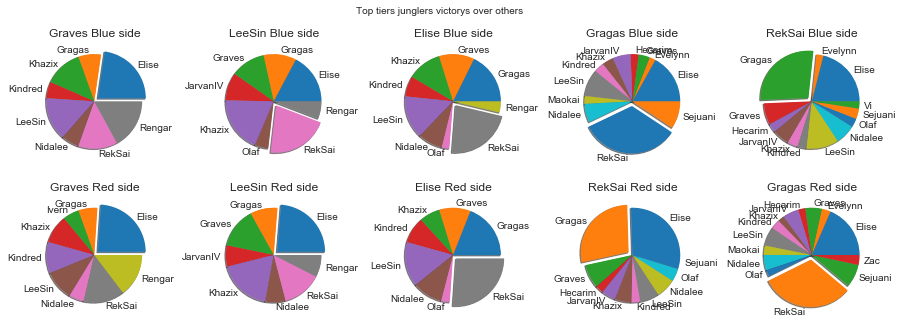

In [13]:
#Plotting
fig, axes = plt.subplots(2, len(blue_champs), figsize=(15,5))
fig.suptitle('Top tiers junglers victorys over others', fontsize=10)
fig.subplots_adjust(wspace=0.5, hspace=0.3)

#Create the plot
def plotPie(fig_index, plt_index, champ, axes, dataset, side):
    indexes = dataset[champ].index
    vals = dataset[champ].values
    explode = [0]*len(indexes)
    explode[np.argmax(vals)] = 0.1
    axes[fig_index][plt_index].pie(vals, labels = indexes, explode = explode, shadow=True)
    axes[fig_index][plt_index].set_title(' '.join((champ, side)))
    axes[fig_index][plt_index].axis('off')
    
for i, (blue_champ, red_champ) in enumerate(zip(blue_champs, red_champs)):
    plotPie(0, i, blue_champ, axes, blue_against_red_filtered, 'Blue side')
    plotPie(1, i, red_champ, axes, red_against_blue_filtered, 'Red side')

# Checking out bans

In [14]:
ban_cols = [col for col in bans.columns if 'ban' in col]
bans_dict = {}
for col in ban_cols:
    serie = bans.groupby([col]).count()['Address']
    bans_dict[col] = pd.DataFrame(serie, index = serie.index).rename({'Address':'ban_1'}, axis=1)

In [15]:
all_bans = pd.concat(bans_dict, axis=0)
all_bans = all_bans.reset_index()

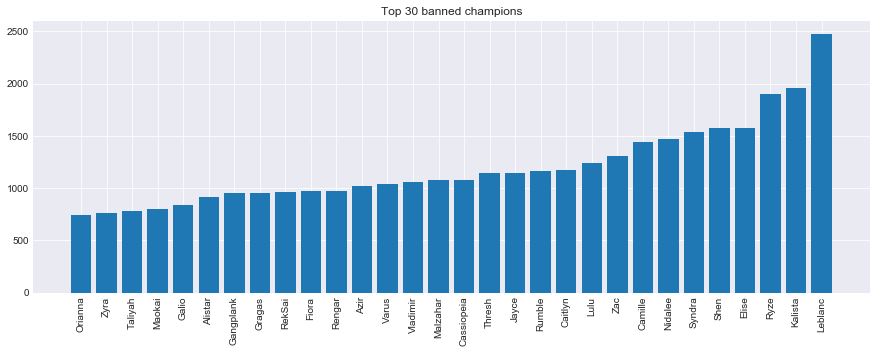

In [16]:
all_bans_sum = all_bans.groupby('level_1').agg('sum')
all_bans_sum.sort_values(by='ban_1', ascending=True, inplace=True)
fig, axes = plt.subplots(figsize=(15,5))
axes.bar(all_bans_sum.index.values[-30:], all_bans_sum.values.ravel()[-30:])
axes.set_title('Top 30 banned champions')
for label in axes.get_xticklabels():
    label.set_rotation(90)

# Conclusion
This is a on going project so I will keep ploting more and more of the data and trying to do more statical analisys then just visuals.